In [1]:
library(ggplot2)
library(extrafont)
library(stringr)
library(heatmaply)
library(ggrepel)
library(reticulate)
library(gridExtra)
library(robustbase)

Registering fonts with R
Loading required package: plotly

Attaching package: ‘plotly’

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked from ‘package:stats’:

    filter

The following object is masked from ‘package:graphics’:

    layout

Loading required package: viridis
Loading required package: viridisLite

Welcome to heatmaply version 0.15.2

Type citation('heatmaply') for how to cite the package.
Type ?heatmaply for the main documentation.

The github page is: https://github.com/talgalili/heatmaply/
Please submit your suggestions and bug-reports at: https://github.com/talgalili/heatmaply/issues
Or contact: <tal.galili@gmail.com>



In [2]:
# Load external Python functions
source_python("reticulate_functions.py")
# Load extra fonts
ttf_import(paths = ".fonts")
loadfonts()
# Set this to true for faster compilation or false for more precise results and all outputs
TEST_MODE = F

Scanning ttf files in .fonts ...
Extracting .afm files from .ttf files...
/home/jovyan/.fonts/Arial.ttf : ArialMT already registered in fonts database. Skipping.
Found FontName for 0 fonts.
Scanning afm files in /opt/conda/lib/R/library/extrafontdb/metrics
Warning message in grepl("^FamilyName", text):
“input string 4 is invalid in this locale”Warning message in grepl("^FontName", text):
“input string 4 is invalid in this locale”Warning message in grepl("^FullName", text):
“input string 4 is invalid in this locale”Warning message in grepl("^Weight", text):
“input string 4 is invalid in this locale”Arial already registered with pdfFonts().


In [3]:
# Number of permutations used for empirical p-value computations
PERM_NB_ITER = ifelse(TEST_MODE, 20, 2000)

In [4]:
# Customize ggplot appearance

# Change theme
customTheme <- theme_light() + 
               theme(panel.grid.minor=element_blank(), text=element_text(size=17, family="Arial", colour = "#333333"),
                     line=element_line(colour = "#333333"), legend.background = element_rect(fill=alpha('#CCCCCC', 0.1)), legend.key = element_blank())

# Change default colors
scale_colour_continuous <- function (..., begin = 0.1, end = 0.9, direction = -1, option = "plasma", 
                                     type = getOption("ggplot2.continuous.colour", default = "viridis")) {
    switch(type, gradient = scale_colour_gradient(...), 
        viridis = scale_colour_viridis_c(option = option, begin = begin, end = end, direction = direction, ...), 
        stop("Unknown scale type", call. = FALSE))
}
scale_color_continuous <- scale_colour_continuous

scale_fill_continuous <- function (..., begin = 0.1, end = 0.9, direction = -1, option = "plasma", 
                                     type = getOption("ggplot2.continuous.colour", default = "viridis")) {
    switch(type, gradient = scale_fill_gradient(...), 
        viridis = scale_fill_viridis_c(option = option, begin = begin, end = end, direction = direction, ...), 
        stop("Unknown scale type", call. = FALSE))

}

cemm_pal = colorRampPalette(c("#5A463C", "#008CAD", "#40B9D4", "#D4ECF2", "#D2323C", "#F8B100", "#DFDC00"))
cust_pal = colorRampPalette(c("#008CAD", "#40B9D4", "#D4ECF2", "#F8B100", "#C00000", "#2D0000"))
yolla_pal = colorRampPalette(c('#FD0F91', '#C00000', '#2D0000'))
scale_fill_discrete <- function (..., type = "CeMM", h = c(0, 360) + 15, c = 100, l = 65, h.start = 0, 
    direction = 1, na.value = "grey50", aesthetics = "fill") 
{
    if (type == "CeMM"){
        discrete_scale(aesthetics, "CeMM", cemm_pal, na.value = na.value, ...)
    } else if (type == "Yolla"){
        discrete_scale(aesthetics, "Yolla", yolla_pal, na.value = na.value, ...)
    } else if (type == "Cust"){
        discrete_scale(aesthetics, "Cust", cust_pal, na.value = na.value, ...)
    } else {
        discrete_scale(aesthetics, "hue", hue_pal(h, c, l, h.start, 
            direction), na.value = na.value, ...)
    }
}

scale_color_discrete <- function (..., type = "CeMM", h = c(0, 360) + 15, c = 100, l = 65, h.start = 0, 
    direction = 1, na.value = "grey50", aesthetics = "colour") {
    if (type == "CeMM"){
        discrete_scale(aesthetics, "CeMM", cemm_pal, na.value = na.value, ...)
    } else if (type == "Cust"){
        discrete_scale(aesthetics, "Cust", cust_pal, na.value = na.value, ...)
    } else if (type == "Yolla"){
        discrete_scale(aesthetics, "Yolla", yolla_pal, na.value = na.value, ...)
    } else {
        discrete_scale(aesthetics, "hue", scales::hue_pal(h, c, l, h.start, 
            direction), na.value = na.value, ...)
    }
}
scale_colour_discrete <- scale_color_discrete

noGridTheme <- function(...){
    theme(panel.grid.major=element_blank(), axis.text.x=element_text(size=12), axis.text.y=element_text(size=12),
                      axis.line=element_line(color="#333333", size = 0.2), panel.border = element_blank(), ...)
}

darkTheme <- function(...){
    theme(panel.background = element_rect(fill = '#333333'), plot.background = element_rect(fill = '#333333'), 
          axis.line=element_line(color="#CCCCCC", size = 0.2), 
          text=element_text(size=17, family="Arial", colour = "#CCCCCC"),
          line=element_line(colour = "#CCCCCC"))
}

theme_set(customTheme)

options(repr.plot.width=10, repr.plot.height=10)

## Load data

In [5]:
N = read.csv("Data/matN.csv", header = F)

In [6]:
R = read.csv("Data/matR.csv", header = F)

In [7]:
PS = read.csv("Data/matPS.csv", header = F)

In [8]:
PR = read.csv("Data/matPR.csv", header = F)

## UMAP

In [9]:
# Fix t-SNE layout and random number generation
set.seed(38)

In [10]:
umArti = umap(rbind(R,N,PS,PR), min_dist = 0.1, neighbors = 10, n = 2, metric = "euclidean")
umArti = as.data.frame(umArti)
names(umArti) = c("UMAP1", "UMAP2")

In [11]:
umArti$Dataset <- rep(c("R","N","PS","PR"), c(2000, 1000, 1000, 1000))

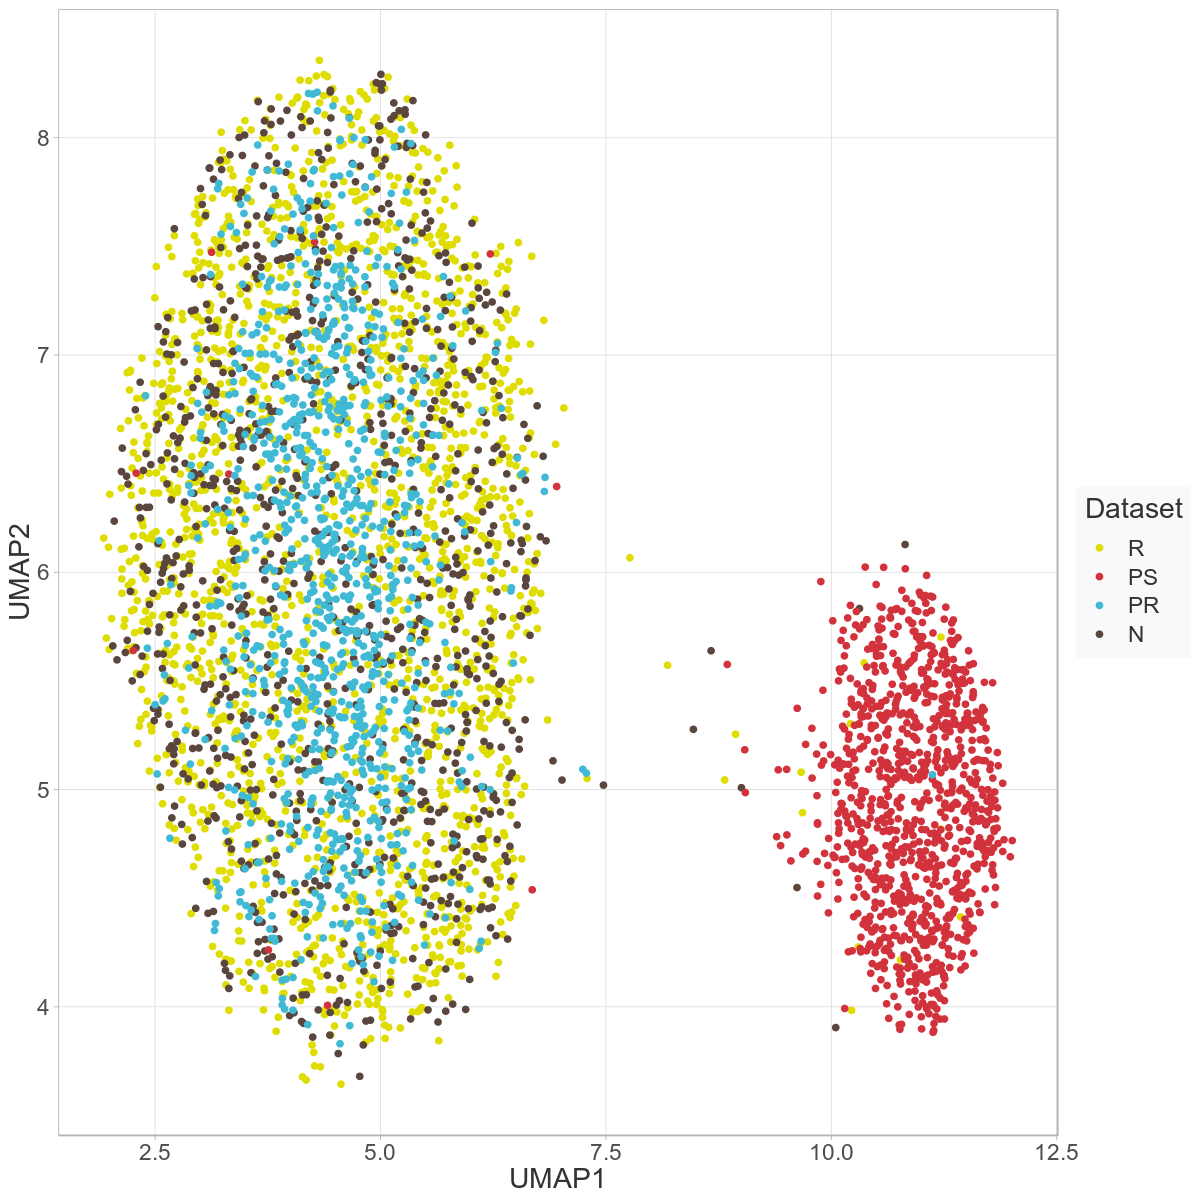

In [12]:
gp <- ggplot(umArti) + geom_point(aes(UMAP1, UMAP2, color = Dataset)) + 
                      guides(color = guide_legend(reverse = TRUE))
gp

In [13]:
umArti = umap(rbind(R,PR), min_dist = 0.1, neighbors = 10, n = 2, metric = "euclidean")
umArti = as.data.frame(umArti)
names(umArti) = c("UMAP1", "UMAP2")

In [14]:
umArti$Dataset <- rep(c("R","PR"), c(2000, 1000))

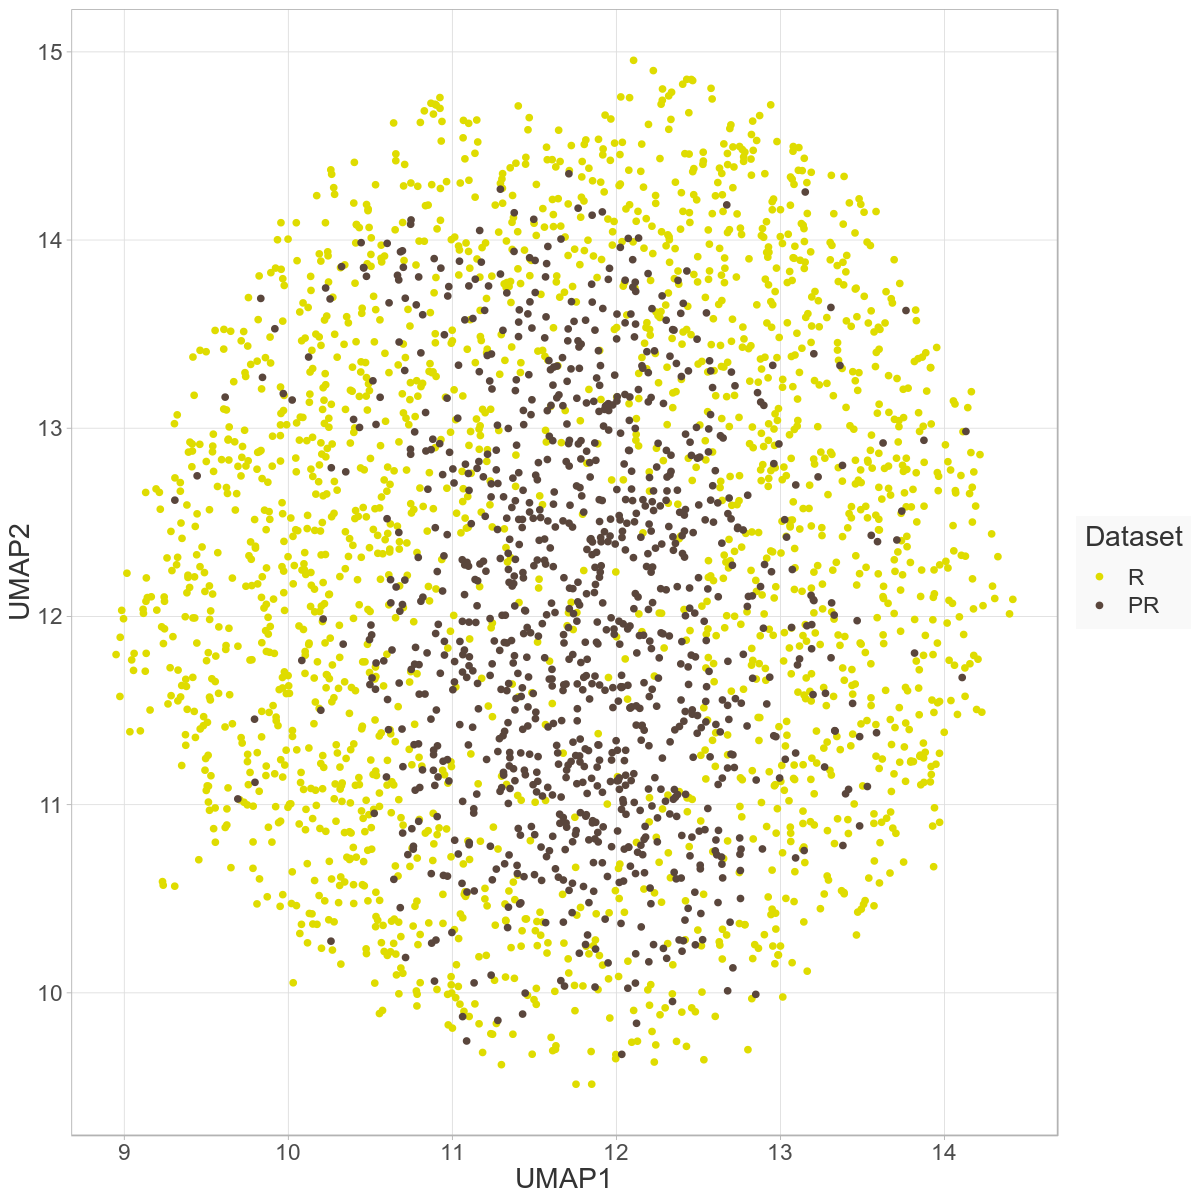

In [15]:
gp <- ggplot(umArti) + geom_point(aes(UMAP1, UMAP2, color = Dataset)) + 
                      guides(color = guide_legend(reverse = TRUE))
gp

## RMP outline

The following plots are then used as example to explain the geometric interpretation of the RMP.

In [16]:
set.seed(38)
subset = rbind(R[sample(2000, 100, replace = F),], PS[sample(1000, 100, replace = F),])
umArti = umap(subset, min_dist = 0.1, neighbors = 10, n = 2, metric = "euclidean")
umArti = as.data.frame(umArti)
names(umArti) = c("UMAP1", "UMAP2")

In [17]:
umArti$Dataset <- rep(c("R","PS"), c(100, 100))

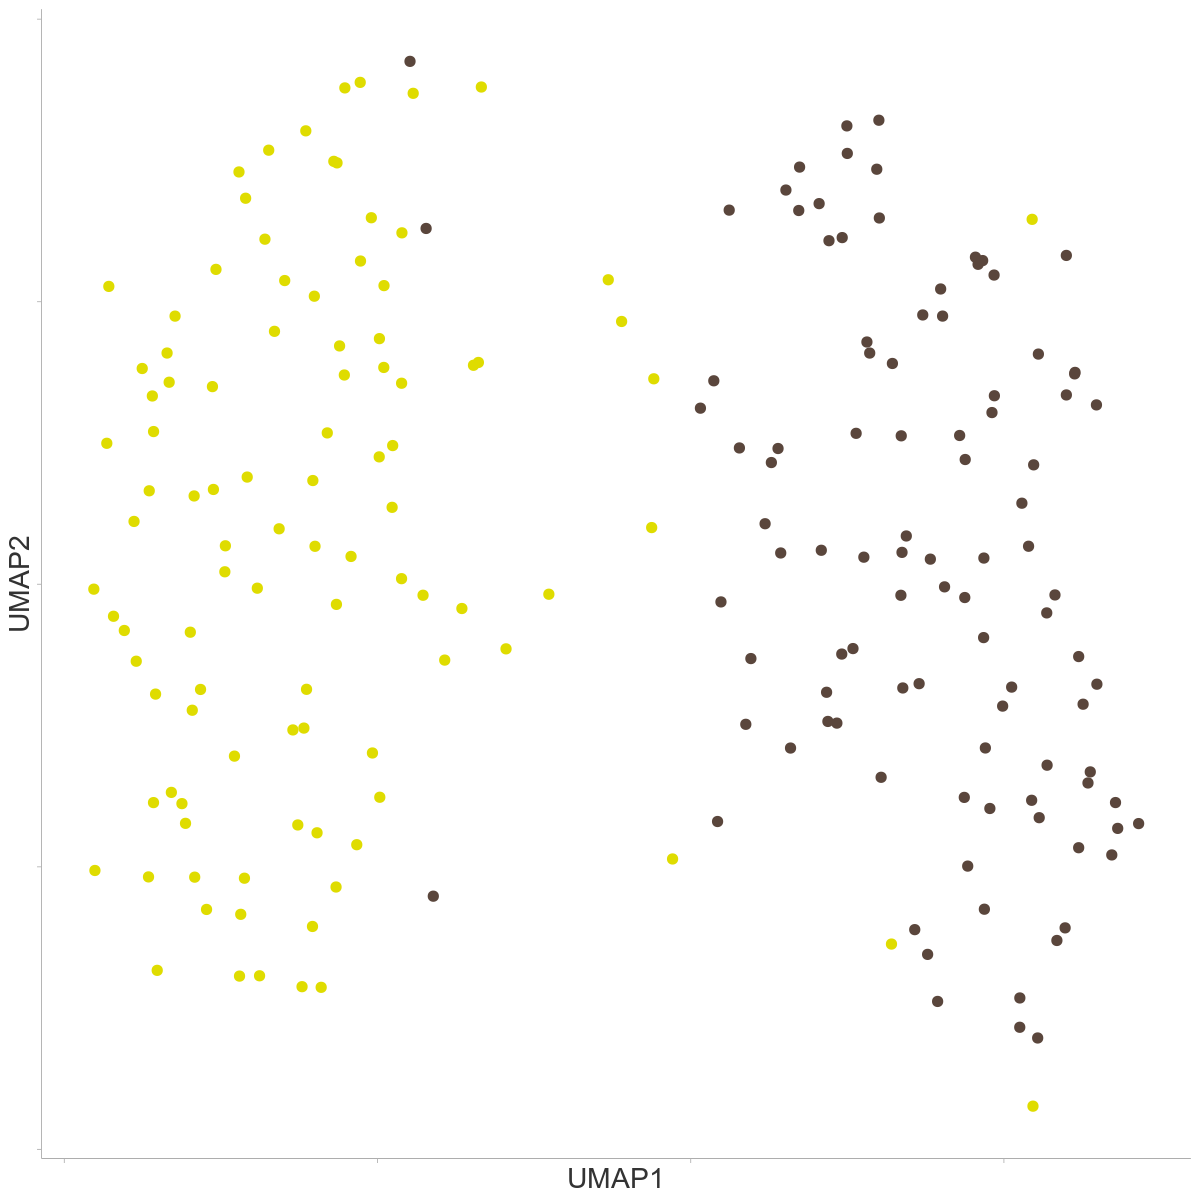

In [18]:
gp <- ggplot(umArti) + geom_point(aes(UMAP1, UMAP2, color = Dataset), size = 2.5) + 
                      guides(color = F) + theme(panel.grid.major=element_blank(), 
                                                axis.text = element_blank(),
                                                axis.line=element_line(color="#333333", size = 0.1), 
                                                panel.border = element_blank())
gp

In [19]:
ggsave("Fig/ExUMAP_sep.pdf", width = 5, height = 5)

In [20]:
umArti$Dataset <- sample(umArti$Dataset)

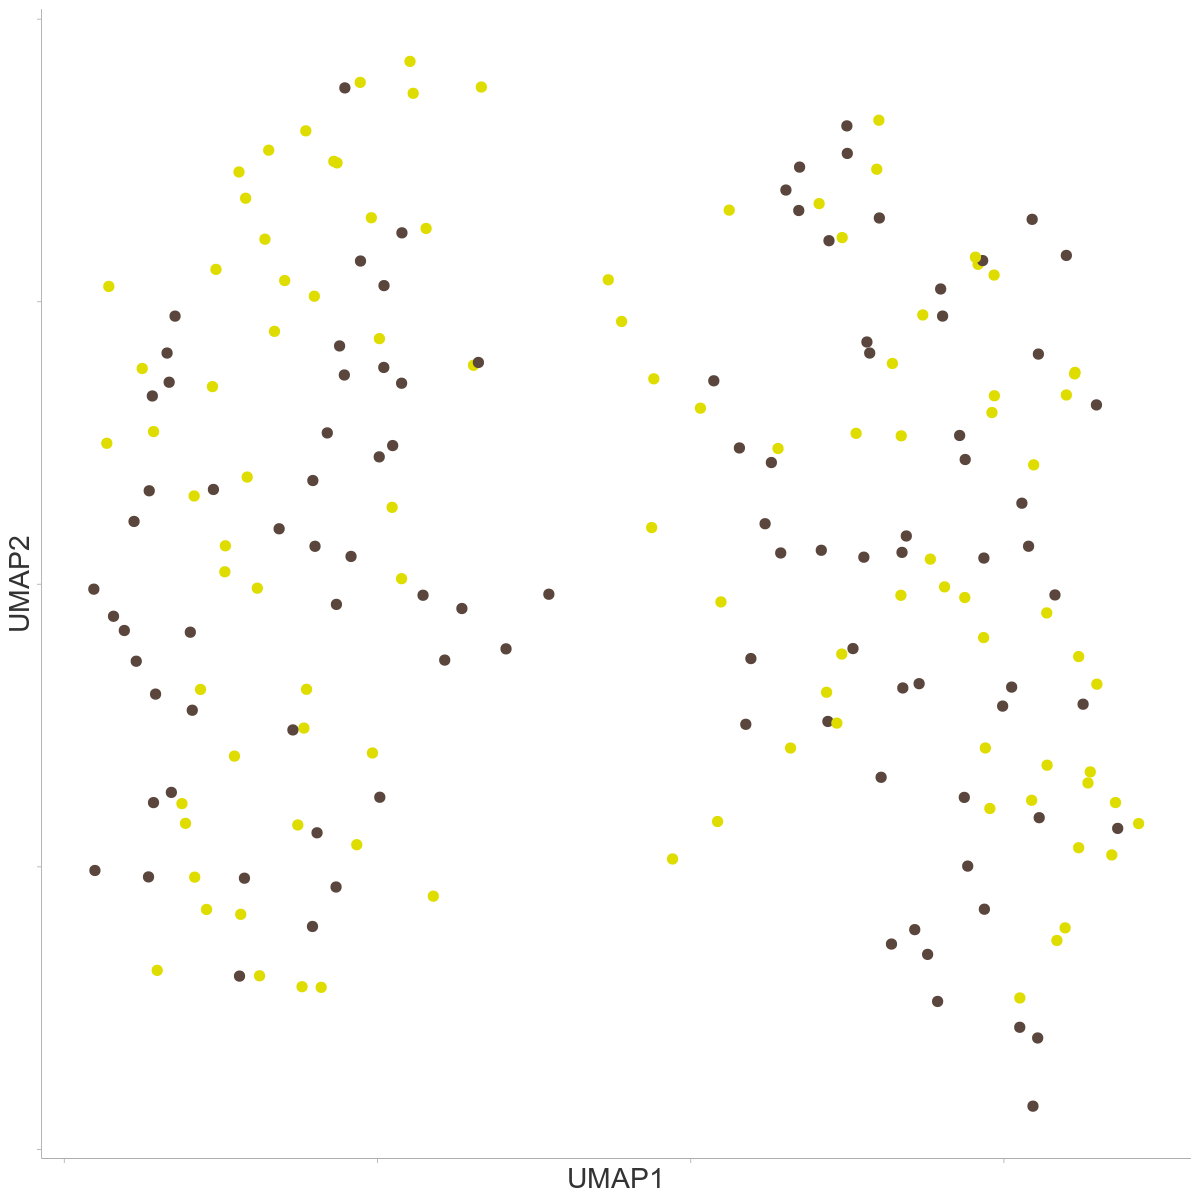

In [21]:
gp <- ggplot(umArti) + geom_point(aes(UMAP1, UMAP2, color = Dataset), size = 2.5) + 
                      guides(color = F) + theme(panel.grid.major=element_blank(), 
                                                axis.text = element_blank(),
                                                axis.line=element_line(color="#333333", size = 0.1), 
                                                panel.border = element_blank())
gp

In [22]:
ggsave("Fig/ExUMAP_ove.pdf", width = 5, height = 5)